<a href="https://colab.research.google.com/github/Mikcl/CellTransformer/blob/wip-no-repeat/Cells_are_Transformers_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linear-attention-transformer
!pip install einops

  Created wheel for product-key-memory: filename=product_key_memory-0.1.10-cp36-none-any.whl size=3072 sha256=517de23fc68c06e563c29492d9a60da32eb7ed9d677c923522e3fcf6fae12ce5
  Stored in directory: /root/.cache/pip/wheels/6d/e0/3b/fd3111a4fac652ed014ccfd4757754f006132723985e229419
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp36-none-any.whl size=2904 sha256=f7fde8f146999cc71bc312f60683489f2aadfdfeff9ca8a5b94f9aaa4acfd015
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
Successfully built product-key-memory axial-positional-embedding


In [2]:
import os
import base64
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import matplotlib.pylab as plt
import glob

import torch.optim as optim

from linear_attention_transformer import LinearAttentionTransformerLM
from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper

from einops import rearrange

clear_output()

In [3]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

# 👁, 🦎
TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing"] # "Persistent", "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [4]:
#@title Transformer Token Details
TOKEN_OFFSET = 2
NUM_TOKENS = 257 + TOKEN_OFFSET
ENC_SEQ_LEN = 9 * CHANNEL_N
DEC_SEQ_LEN = CHANNEL_N

In [16]:
#@title Tranformer Hyperparameters 

EPOCHS = 1000 #int(1e3)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# GENERATE_EVERY  = 100   # For visual results during training. . 

In [6]:
#@title Helpers 

def to_rgba(x):
  return x[:,:4,:,:]

def to_rgb(x):
  return x[:,:3,:,:]

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


In [7]:
#@title Load image utils. 

# Returns h,w,c image where c=RGBA
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  return load_image(url)

In [8]:
#@title To Device
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)  

In [9]:
#@title Load Emoji
target_img = load_emoji(TARGET_EMOJI)

In [10]:
p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]

# (CHANNEL_N, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 255

pad_target = pad_target.permute(2, 0, 1)

In [11]:
pad_target = pad_target.to(device)

def loss_f(x):
    x = x[:,:4,:,:]
    return torch.mean(torch.square(x-pad_target), [-1,-2,-3])

In [12]:
#@title Masking Utils
IMAGE_BATCH_SIZE = 1 #number of images to concurrently train on. 
LIVE_MIN = 10

# Applied on default/non-tokenized values
def get_living_mask(x):
  alpha = x[:, 3:4, :, :]
  return torch.nn.functional.max_pool2d(input=alpha, kernel_size=3, stride=1, padding=1) > LIVE_MIN

# 3d tensor as boolean. 
alive_target_mask = get_living_mask(pad_target[None,...])

def get_dilatied_mask(x):
  # Returns x dilated mask as FloatType 
  output = x.sum(-3) > 0
  output = output.type(torch.FloatTensor)
  kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.FloatTensor)
  dilated = torch.nn.functional.conv2d(output[None,...], kernel[None, None, ...].expand(1, -1, -1, -1), groups=1, padding=1)
  return dilated

def get_living_target(x):
  living_mask = get_living_mask(x)

  # print('SUM OF 1s', torch.sum(torch.flatten(living_mask)))
  living_target_mask = (living_mask & alive_target_mask)
  living_target = pad_target[None,...] * living_target_mask.float()
  living_target = living_target[0]
  return living_target

def mask_target(mask):
  '''
    mask - tensor: 2D - Float

    returns - tensor: 4D - T
  '''
  # returns 4d tensor. 
  target_batch = pad_target[None, ...] * mask
  return target_batch


In [13]:
#@title Define Model

def tokenize(x):
  return (x + 2).long()

def detokenize(x):
  return (x - 2).long()

def percieve(x):
  # x - 4d tensor - N, C, H, W
  _,_,h,w = x.shape
  padded_x = torch.nn.functional.pad(x, pad=(1,1,1,1), mode='constant', value=0)
  stacked_image = torch.cat(
      [padded_x[:,:,i:i+h, j:j+w]  for j in range(3) for i in range(3)]
      ,1
  )
  return stacked_image


# instantiate model
enc = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 4,
    max_seq_len = ENC_SEQ_LEN,
    one_kv_head = True,
    return_embeddings = True
).to(device)

dec = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 6,
    causal = True,
    blindspot_size = 1,             # a small blindspot greatly saves on memory
    max_seq_len = DEC_SEQ_LEN,
    one_kv_head = True,
    receives_context = True
).to(device)

dec = AutoregressiveWrapper(dec)

# optimizer

optim = torch.optim.Adam([*enc.parameters(), *dec.parameters()], lr=LEARNING_RATE)


In [14]:
#@title Dataset Generation Helpers. 
SENTENCES = int(alive_target_mask.shape[2] * alive_target_mask.shape[3])

class CellTraining(Dataset):
    def __init__(self, X, Y):
        self.src = X
        self.tgt = Y
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'

        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.TGT_MASK = torch.ones(b, DEC_SEQ_LEN).bool()

        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]
        src_mask = self.SRC_MASK[idx]
        tgt_mask = self.TGT_MASK[idx] 
        return src.to(device), tgt.to(device), src_mask.to(device), tgt_mask.to(device)


class CellEvaluating(Dataset):
    def __init__(self, X):
        self.src = X
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        src_mask = self.SRC_MASK[idx]
        return src.to(device), src_mask.to(device)



def get_start_tokens(number_of_sentences):
    return torch.ones((number_of_sentences, 1)).long().to(device)

def image_to_sentences(x):
  '''
    ## maps a 3D tensor of shape (c, h, w) to a 2D tensor of (h*w, c)
    these are known as sentences or 'patches' of size one
  '''
  return rearrange(x,'c h w -> (h w) c')


def sentences_to_image(x, height, width):
  '''
    ## maps a 2D tesnor of shape (h*w, c) to image/3D tensor shape of (c, h, w)
    inverse of image_to_sentence
    height: int - image dimension
    width: int - image dimension
  '''
  return rearrange(x, '(h w) (p1 p2 c) -> c (h p1) (w p2)', p1 =1, p2 =1, h=height, w=width)


def visualize_batched(x, c=4):
  x = x[:,:c,:,:].cpu().numpy()
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))
  plt.imshow(vis1)
  plt.show()







training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



UDIS: [9, 25, 49, 81, 119, 167, 220, 276, 344, 421, 503, 590, 680, 776, 864, 959, 1070, 1173, 1274, 1395, 1513, 1626, 1754, 1871, 2008, 2159, 2308, 2460, 2611, 2768]


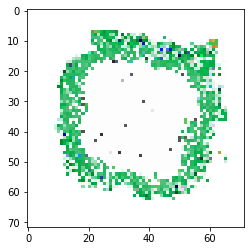




training epochs:   0%|          | 1/1000 [00:54<15:12:41, 54.82s/it]

KeyboardInterrupt: ignored

In [21]:
#@title Training { vertical-output: true}


# training
log_loss = []
UPDATE_STEPS = 21 # 21
SENTENCE_BATCH = 32
TRAIN_ON=False 
EVAL_STEPS = 30
VISUALISE_EVERY = 20

def get_X_values(x, mask=None):
  # X values
  percieved_images = percieve(x)
  X_img = percieved_images[0]

  # TODO - optional mask here? 
  X_img = X_img if mask==None else (X_img[None,...] * mask)[0]

  X_seq_un_clean = image_to_sentences(X_img)
  valid_instances = (torch.tensor(X_seq_un_clean).bool().float().sum(dim=-1) != 0).nonzero().flatten().long()

  X_seq_cleaned = X_seq_un_clean[valid_instances]

  X_seq = tokenize(X_seq_cleaned)
  return valid_instances, X_seq


# X - 4d tensor - maybe move this
def get_input_values(x):
  step_output_float_mask = get_dilatied_mask(x).to(device)

  valid_instances, X_seq = get_X_values(x)

  return step_output_float_mask, valid_instances, X_seq

def get_update_values(x, step_float, seen_float):
  training_float = (step_float.bool() ^ seen_float.bool()).float()
  seen_float = (training_float.bool() ^ seen_float.bool()).float()

  # TODO - use training float to extract valid instances
  valid_instances, X_seq = get_X_values(x, training_float)

  return training_float, valid_instances, X_seq, seen_float

def get_X0():
  x0 = np.repeat(seed[None,...], IMAGE_BATCH_SIZE, 0)
  x0 = torch.Tensor(x0).to(device)
  return x0

next_token_loss = [['EPOCH', 'STEP', 'LOSS']]
epoch_losses = []

for i in tqdm.tqdm(range(EPOCHS), mininterval=10., desc='training epochs'):
    x = get_X0()

    step_loss = []

    seen_float = (get_living_mask(x).float() * 0).to(device);
    prev_N = 0
    
    for step in tqdm.auto.tqdm(range(UPDATE_STEPS), mininterval=1., desc='update step'):
      update_step_loss = []
      step_output_float_mask, valid_instances, X_seq = get_input_values(x)

      if (TRAIN_ON): 
        u_step_output_float_mask, u_valid_instances, u_X_seq, seen_float = get_update_values(x, step_output_float_mask, seen_float)
        N = len(u_valid_instances)

        if (N != 0 or N == 0):
          training_float_mask, valid_instances, X_seq = u_step_output_float_mask, u_valid_instances, u_X_seq
        else:
          training_float_mask = step_output_float_mask

        # target 
        y_target = mask_target(training_float_mask.bool().float())[0]
        # Extend y _ target channels here.

        # Prefix
        prefix = get_start_tokens(X_seq.shape[0])

        # Y valyes from target
        y_seq_un_cleaned = image_to_sentences(y_target)
        y_seq_cleaned = y_seq_un_cleaned[valid_instances]
        y_seq = tokenize(y_seq_cleaned)
        Y_seq = torch.cat([prefix, y_seq], 1)

        # Derive dataset for training.
        dataset = CellTraining(X_seq, Y_seq)
        BS = 1 if X_seq.shape[0] < 20 else SENTENCE_BATCH 

        data_loader = DataLoader(dataset=dataset, batch_size=BS, shuffle=True)
           
        enc.train(), dec.train()
        for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
          context = enc(src, input_mask = src_mask)
          loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
          loss.backward()
          loss_value = loss.item()
          next_token_loss.append([i, step, loss_value])
          update_step_loss.append(loss_value)
          optim.step()
          optim.zero_grad()
        step_loss.append(sum(update_step_loss)/len(update_step_loss))

      x = mask_target(step_output_float_mask.bool().float()).to(device)

    epoch_losses.append(step_loss)

    # Generate:
    if (EVAL_STEPS > 0 and i % VISUALISE_EVERY == 0):
      x = get_X0() # x # get_X0()
      udis = []
      enc.eval(), dec.eval()
      for step in tqdm.auto.tqdm(range(EVAL_STEPS), mininterval=1., desc='evaluation step'):
        output_seq = torch.zeros(SENTENCES, CHANNEL_N).long().to(device) # image_to_sentences(x[0]).long()

        step_output_float_mask, update_instances, X_seq = get_input_values(x)

        update_instances = update_instances

        udis.append(len(update_instances))

        dataset = CellEvaluating(X_seq)
        data_loader = DataLoader(dataset=dataset, batch_size=SENTENCE_BATCH, shuffle=False)
        
        generated= torch.zeros(X_seq.shape[0], CHANNEL_N).long().to(device)

        for batch_i , (src, src_mask) in enumerate(data_loader):
          start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

          context = enc(src) # original
          # context = enc(src, input_mask = src_mask) 
          
          sample = dec.generate(start_tokens, DEC_SEQ_LEN , context = context)
          # print('sAMPLE', sample, X_seq)
          predicted_cells = sample[:, - CHANNEL_N: ]
          s = batch_i*SENTENCE_BATCH
          
          locations = torch.arange(s,s+predicted_cells.shape[0])

          generated[locations] = predicted_cells

        output_seq[update_instances] = detokenize(generated)
        # print('instance zero', output_seq[update_instances[0]])
        output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
        
        x = output_img[None,...]
      print(f'UDIS: {udis}')
      visualize_batched(x.detach().clone())
    
    if (TRAIN_ON and i % VISUALISE_EVERY == 0):
      plt.figure()
      for ep, l in enumerate(epoch_losses):
        plt.plot(l, label=f'EPOCH-{ep}')

      plt.xlabel("Step")
      plt.ylabel("Loss")
      plt.title(f"epoch-{i}")
      plt.legend()
      plt.show()

      epoch_losses = []

      
    # TODO - produced x - calculate l2 loss and add to log loss - need alignment first